In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import os
import matplotlib.pyplot as plt
import shutil, glob
from random import shuffle
import numpy as np

# Shapes Classification

In this notebook, I build a model to predict whether a given image is either a circle, square or a triangle. The dataset I use for this task is taken from https://www.kaggle.com/cactus3/basicshapes. 

The dataset contains $300$ grayscale images of dimension $28 \times 28$. There are $100$ images each of circles, squares and triangles. Clearly the dataset is very small, considering the fact that we will have to split the dataset into training, validation and test sets.

Below is just a helper function to plot the accuracies for each epoch.

In [2]:
# Plot accuracies vs epoch
def plotAcc(result):
    acc = result.history['acc']
    validation_acc = result.history['val_acc']
    
    x = range(1,len(acc)+1)

    plt.plot(x,acc,'b',label = 'Training Accuracy')
    plt.plot(x,validation_acc,'m',label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

Since the dataset isn't divided into training, validation and test sets, I will have to do it on my own, taking into account that shuffling the images is necessary. 

Initially, the images are located in the `shapes` directory. Using the `os` and `shutil` libraries, I will copy images randomly and create training, validation and test directories containing the images. I will use $60\%$ of the images for training, $20\%$ for validation and $20\%$ for testing. 

In [3]:
base = os.getcwd()
shapes = os.listdir(os.path.join(base,'shapes'))[1:]
shape_dict = {shape: os.listdir(os.path.join(base, 'shapes',shape)) for shape in shapes}

In [4]:
# Create train, test and val directories in the working directory
train = os.path.join(base,'train')
val = os.path.join(base,'val')
test = os.path.join(base, 'test')

os.mkdir(train)
os.mkdir(test)
os.mkdir(val)

In [5]:
for shape in shape_dict:
    # Shuffle the images so that the images in train, test and validation sets are random
    shuffle(shape_dict[shape])
    
    # Make circle, square and triangle sub-directories in each of the train, test and val directories
    os.mkdir(os.path.join(train, shape))
    os.mkdir(os.path.join(test, shape))
    os.mkdir(os.path.join(val, shape))
    
    # Start copying the images
    for img in shape_dict[shape][:60]:
        img_path = os.path.join(base,'shapes',shape,img)
        shutil.copy(img_path, os.path.join(train, shape))
        
    for img in shape_dict[shape][60:80]:
        img_path = os.path.join(base,'shapes',shape,img)
        shutil.copy(img_path, os.path.join(test, shape))
        
    for img in shape_dict[shape][80:]:
        img_path = os.path.join(base,'shapes',shape,img)
        shutil.copy(img_path, os.path.join(val, shape))  

Let's use Keras's `ImageDataGenerator` to generate batches of images from the directories we just created

In [6]:
datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_data = datagen.flow_from_directory(train, color_mode = 'grayscale', target_size = (28,28))
val_data  = datagen.flow_from_directory(val, color_mode = 'grayscale', target_size = (28,28))
test_data = datagen.flow_from_directory(test, color_mode = 'grayscale', target_size = (28,28))

Found 180 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


Let's look at some of the train images

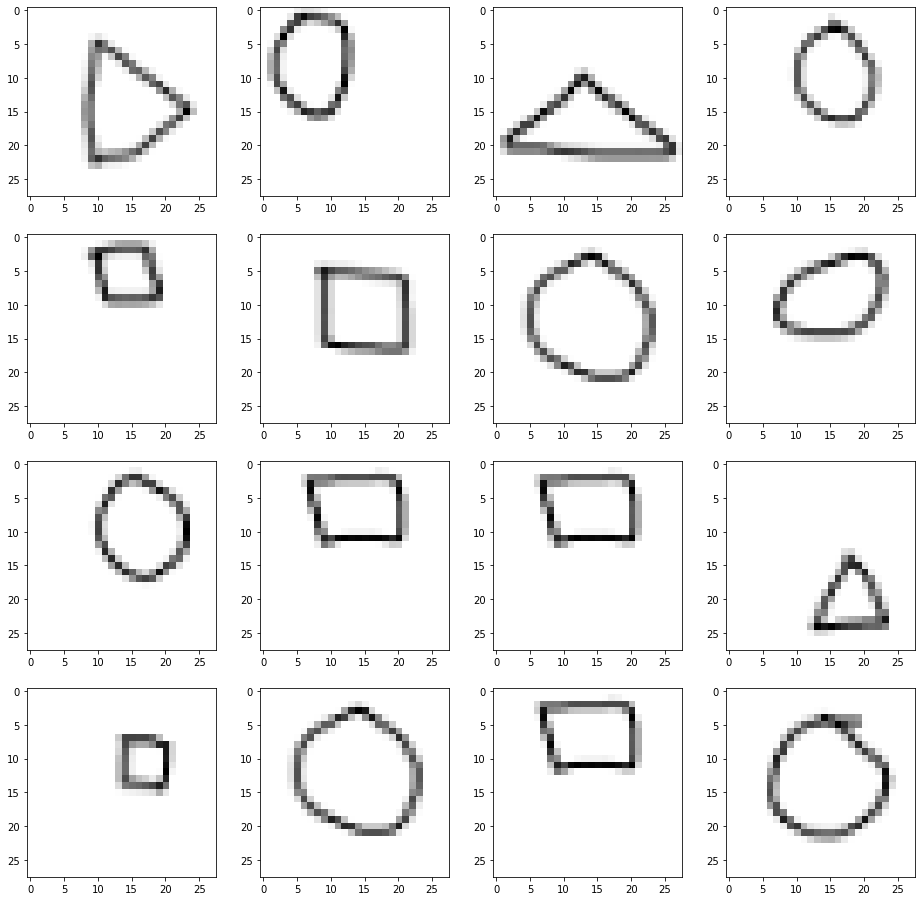

In [8]:
fig, ax = plt.subplots(4,4,figsize=(16,16))
for i in range(16):
    ind = np.random.randint(32)
    image = train_data[0][0][ind]
    ax[i//4][i%4].imshow(image, cmap='gray')

We will use Keras's <b>Sequential</b> API to create our model layer by layer. 

In [9]:
model = models.Sequential ([
            # First convolution layer with 32 3x3 filters
            layers.Conv2D(32, (3, 3), activation='relu',input_shape=(28, 28,1)),
            # First Pooling Layer
            layers.MaxPooling2D((2, 2)),
    
            # Second convolution layer with 64 3x3 filter
            layers.Conv2D(64, (3, 3), activation='relu'),
            # Second Pooling layer
            layers.MaxPooling2D((2, 2)),
    
            # The Denseley connected neural network below or convolutional base
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(3, activation='softmax')
        ])

Let's look at how our model looks.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

Now we compile the model. Since it's a multiclass classification problem, we will use `categorical_crossentropy` as our loss function

In [11]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['acc'])

Let's fit the model now.

In [12]:
result = model.fit(train_data, epochs = 50, validation_data = val_data)

Epoch 1/50
6/6 [==============================] - 0s 48ms/step - loss: 1.1089 - acc: 0.2944 - val_loss: 1.0933 - val_acc: 0.3833
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0962 - acc: 0.3944 - val_loss: 1.0909 - val_acc: 0.3333
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0945 - acc: 0.3611 - val_loss: 1.0836 - val_acc: 0.4000
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0741 - acc: 0.5222 - val_loss: 1.0666 - val_acc: 0.5833
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0610 - acc: 0.5222 - val_loss: 1.0495 - val_acc: 0.6000
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0380 - acc: 0.5500 - val_loss: 1.0241 - val_acc: 0.6000
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 0.9973 - acc: 0.6056 - val_loss: 0.9906 - val_acc: 0.6667
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.9531 - acc: 0.6167 - val

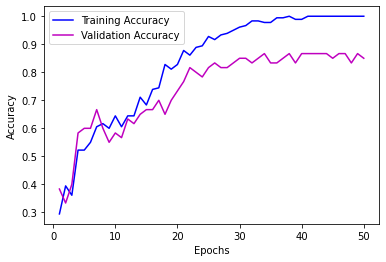

<Figure size 432x288 with 0 Axes>

In [13]:
plotAcc(result)

It's clear that our model is overfitting. One of the main reasons for that is that our dataset is super small. We only use $180$ images for training, which is very less. No wonder our validation accuracy is so less as compared to our training accuracy.

To tackle overfitting, we will use Data/Image Augmentation where we basically create new training data from the already existing training data in real time. For example, we can flip all the images vertically and a square will still remain a square, a triangle will still remain a triangle and a circle will still be a circle. And now we have another $180$ images in our training set.

Keras's `ImageDataGenerator` has a lot of options for Image Augmentation. For this task, I will only use `horizontal_flip` and `vertical_flip`. 

In [14]:
datagen_aug = ImageDataGenerator(horizontal_flip = True,
                                vertical_flip = True,
                                rescale = 1./255)

train_aug = datagen_aug.flow_from_directory(train, color_mode = 'grayscale', target_size = (28,28))
                                

Found 180 images belonging to 3 classes.


Let's clone our older model to train on this new augmented dataset.

In [15]:
model_aug = models.clone_model(model)

In [16]:
model_aug.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['acc'])

In [17]:
result_aug = model_aug.fit(train_aug, epochs = 50, validation_data = val_data)

Epoch 1/50
6/6 [==============================] - 0s 37ms/step - loss: 1.1323 - acc: 0.3222 - val_loss: 1.1065 - val_acc: 0.3333
Epoch 2/50
6/6 [==============================] - 0s 20ms/step - loss: 1.1284 - acc: 0.3333 - val_loss: 1.1069 - val_acc: 0.3333
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 1.1004 - acc: 0.3333 - val_loss: 1.0978 - val_acc: 0.3500
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0974 - acc: 0.3278 - val_loss: 1.0972 - val_acc: 0.3333
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 1.1023 - acc: 0.3333 - val_loss: 1.0962 - val_acc: 0.3333
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0944 - acc: 0.4111 - val_loss: 1.0948 - val_acc: 0.3833
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0926 - acc: 0.4611 - val_loss: 1.0901 - val_acc: 0.4000
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0919 - acc: 0.4111 - val

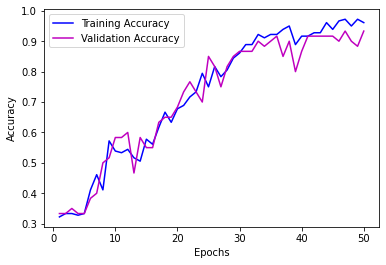

<Figure size 432x288 with 0 Axes>

In [18]:
plotAcc(result_aug)

It's clear that our model is no longer overfitting because of a larger training sample due to image augmentation. The validation curves are closely tracking the training curves for the most part, with some hiccups in between.

Let's finally see how both our models performs on unseen data i.e. the test set.

In [19]:
_, test_accuracy = model.evaluate(test_data, verbose = False)
_, test_accuracy_aug = model_aug.evaluate(test_data, verbose = False)

In [20]:
print(f'Test accuracy without augmentation = {test_accuracy*100:.2f}%')
print(f'Test accuracy with augmentation = {test_accuracy_aug*100:.2f}%')

Test accuracy without augmentation = 86.67%
Test accuracy with augmentation = 91.67%
